In [1]:
import os 
import glob 
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import jax 
import jax.numpy as jnp
from jax import jvp
import optax
from flax import linen as nn 

from typing import Sequence
from functools import partial

import numpy as np

import time
from tqdm import trange

import pickle

In [3]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [4]:
b_bottom = np.load('/userhome/jeon_mg/workspace/project/NF2_notebooks/b_slices.npy')

In [5]:
b_bottom.shape

(513, 257, 1, 3)

In [6]:
boundary_data = b_bottom.squeeze()
boundary_data.shape

(513, 257, 3)

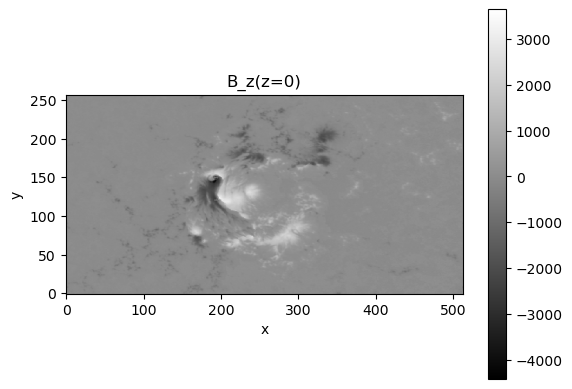

In [7]:
fig, ax = plt.subplots()
CS = plt.imshow(boundary_data[:, :, 2].transpose(), origin='lower', cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("B_z(z=0)")
fig.colorbar(CS)
plt.show()

In [8]:
Nz = 257
b_norm = 2500

Nx, Ny, _ = boundary_data.shape

epochs = 10000
log_iter = 1000

features = 256
n_layers = 8
feat_sizes = tuple([features for _ in range(n_layers)]) 
r = 256 
out_dim = 3 

lr = 5e-4

pos_enc = 0
mlp = 'modified_mlp'

parameters = {'feat_sizes' : feat_sizes, 
              'r' : r, 
              'out_dim' : out_dim, 
              'Nx' : Nx, 
              'Ny' : Ny, 
              'Nz' : Nz, 
              'b_norm' : b_norm,
              'pos_enc' : pos_enc,
              'mlp' : mlp}

parameters_path = "parameters.pickle"
with open(parameters_path, "wb") as f:
    pickle.dump(parameters, f)

In [9]:
boundary_data = (boundary_data/b_norm,)

In [10]:
from cmspinn.cms_jaxx import SPINN3d, generate_train_data, apply_model_spinn, update_model

In [11]:
seed = 111
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key, 2)

model = SPINN3d(feat_sizes, r, out_dim, pos_enc=pos_enc, mlp=mlp)
params = model.init(
            subkey,
            jnp.ones((Nx, 1)),
            jnp.ones((Ny, 1)),
            jnp.ones((Nz, 1))
        )
apply_fn = jax.jit(model.apply)
optim = optax.adam(learning_rate=lr)
state = optim.init(params)

key, subkey = jax.random.split(key, 2)
train_data = generate_train_data(subkey, Nx, Ny, Nz)
train_boundary_data = [train_data, boundary_data]

losses = []

2023-10-11 10:40:53.345644: W external/xla/xla/service/gpu/nvptx_compiler.cc:703] The NVIDIA driver's CUDA version is 11.4 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [12]:
loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
losses.append(loss.item())
params, state = update_model(optim, gradient, params, state)

In [13]:
start = time.time()
for e in trange(1, epochs + 1):

    loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
    losses.append(loss.item())
    params, state = update_model(optim, gradient, params, state)
    
    if e % log_iter == 0:
        print(f'Epoch: {e}/{epochs} --> total loss: {loss:.8f}')
        params_path = f"params_{e}.pickle"
        with open(params_path, "wb") as f:
            pickle.dump(params, f)

np.save('losses.npy', losses)
runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(epochs-1)*1000):.2f}ms/iter.)')

  2%|▏         | 209/10000 [00:25<20:06,  8.12it/s]


KeyboardInterrupt: 